## Garment Segmentation project

### The Data

In [1]:
import os
import cv2     
import glob
import numpy as np
from tqdm import tqdm
from keras.preprocessing import image                  
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split


file_img_paths = sorted(glob.glob("./input_CP/original/*.png"))
file_seg_paths = sorted(glob.glob("./input_CP/masks/*.png"))     
    
orig_train = file_img_paths[0:900]
orig_valid = file_img_paths[900:]
seg_train = file_seg_paths[0:900]
seg_valid = file_seg_paths[900:]


def path_to_tensor(img_path, is_mask):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) if is_mask else cv2.imread(img_path)
    img_scaled = cv2.resize(img,(1024, 1024))
    x = image.img_to_array(img_scaled)
    x = np.expand_dims(x, axis=0)
    return x

def paths_to_tensor(img_paths, is_mask):
    list_of_tensors = [path_to_tensor(img_path, is_mask) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

orig_train_tensors = paths_to_tensor(orig_train, False).astype('float32')/255
seg_train_tensors = paths_to_tensor(seg_train, True).astype('float32')/255
orig_valid_tensors = paths_to_tensor(orig_valid, False).astype('float32')/255
seg_valid_tensors = paths_to_tensor(seg_valid, True).astype('float32')/255

# print statistics about the dataset
print('There are %s total images.\n' % len(np.hstack([orig_train, orig_valid, seg_train, seg_valid])))
print('There are %d training images.' % len(orig_train))
print('There are %d training mask images.' % len(seg_train))
print('There are %d validation images.' % len(orig_valid))
print('There are %d validation mask images.' % len(seg_valid))

print(orig_train_tensors.shape)
print(seg_train_tensors.shape)
print(orig_valid_tensors.shape)
print(seg_valid_tensors.shape)


Using TensorFlow backend.
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
100%|██████████| 184/184 [00:02<00:00, 61.52it/s]


There are 2168 total images.

There are 900 training images.
There are 900 training mask images.
There are 184 validation images.
There are 184 validation mask images.
(900, 1024, 1024, 3)
(900, 1024, 1024, 1)
(184, 1024, 1024, 3)
(184, 1024, 1024, 1)


### The Model

In [2]:
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Activation, UpSampling2D, BatchNormalization

def unet_1024_segmentation_model(input_shape=(1024, 1024, 3), num_classes=1):
    inputs = Input(shape=input_shape)
    # 1024

    down0b = Conv2D(8, (3, 3), padding='same')(inputs)
    down0b = BatchNormalization()(down0b)
    down0b = Activation('relu')(down0b)
    down0b = Conv2D(8, (3, 3), padding='same')(down0b)
    down0b = BatchNormalization()(down0b)
    down0b = Activation('relu')(down0b)
    down0b_pool = MaxPooling2D((2, 2), strides=(2, 2))(down0b)
    # 512

    down0a = Conv2D(16, (3, 3), padding='same')(down0b_pool)
    down0a = BatchNormalization()(down0a)
    down0a = Activation('relu')(down0a)
    down0a = Conv2D(16, (3, 3), padding='same')(down0a)
    down0a = BatchNormalization()(down0a)
    down0a = Activation('relu')(down0a)
    down0a_pool = MaxPooling2D((2, 2), strides=(2, 2))(down0a)
    # 256

    down0 = Conv2D(32, (3, 3), padding='same')(down0a_pool)
    down0 = BatchNormalization()(down0)
    down0 = Activation('relu')(down0)
    down0 = Conv2D(32, (3, 3), padding='same')(down0)
    down0 = BatchNormalization()(down0)
    down0 = Activation('relu')(down0)
    down0_pool = MaxPooling2D((2, 2), strides=(2, 2))(down0)
    # 128

    down1 = Conv2D(64, (3, 3), padding='same')(down0_pool)
    down1 = BatchNormalization()(down1)
    down1 = Activation('relu')(down1)
    down1 = Conv2D(64, (3, 3), padding='same')(down1)
    down1 = BatchNormalization()(down1)
    down1 = Activation('relu')(down1)
    down1_pool = MaxPooling2D((2, 2), strides=(2, 2))(down1)
    # 64

    down2 = Conv2D(128, (3, 3), padding='same')(down1_pool)
    down2 = BatchNormalization()(down2)
    down2 = Activation('relu')(down2)
    down2 = Conv2D(128, (3, 3), padding='same')(down2)
    down2 = BatchNormalization()(down2)
    down2 = Activation('relu')(down2)
    down2_pool = MaxPooling2D((2, 2), strides=(2, 2))(down2)
    # 32

    down3 = Conv2D(256, (3, 3), padding='same')(down2_pool)
    down3 = BatchNormalization()(down3)
    down3 = Activation('relu')(down3)
    down3 = Conv2D(256, (3, 3), padding='same')(down3)
    down3 = BatchNormalization()(down3)
    down3 = Activation('relu')(down3)
    down3_pool = MaxPooling2D((2, 2), strides=(2, 2))(down3)
    # 16

    down4 = Conv2D(512, (3, 3), padding='same')(down3_pool)
    down4 = BatchNormalization()(down4)
    down4 = Activation('relu')(down4)
    down4 = Conv2D(512, (3, 3), padding='same')(down4)
    down4 = BatchNormalization()(down4)
    down4 = Activation('relu')(down4)
    down4_pool = MaxPooling2D((2, 2), strides=(2, 2))(down4)
    # 8

    center = Conv2D(1024, (3, 3), padding='same')(down4_pool)
    center = BatchNormalization()(center)
    center = Activation('relu')(center)
    center = Conv2D(1024, (3, 3), padding='same')(center)
    center = BatchNormalization()(center)
    center = Activation('relu')(center)
    # center

    up4 = UpSampling2D((2, 2))(center)
    up4 = concatenate([down4, up4], axis=3)
    up4 = Conv2D(512, (3, 3), padding='same')(up4)
    up4 = BatchNormalization()(up4)
    up4 = Activation('relu')(up4)
    up4 = Conv2D(512, (3, 3), padding='same')(up4)
    up4 = BatchNormalization()(up4)
    up4 = Activation('relu')(up4)
    up4 = Conv2D(512, (3, 3), padding='same')(up4)
    up4 = BatchNormalization()(up4)
    up4 = Activation('relu')(up4)
    # 16

    up3 = UpSampling2D((2, 2))(up4)
    up3 = concatenate([down3, up3], axis=3)
    up3 = Conv2D(256, (3, 3), padding='same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = Activation('relu')(up3)
    up3 = Conv2D(256, (3, 3), padding='same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = Activation('relu')(up3)
    up3 = Conv2D(256, (3, 3), padding='same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = Activation('relu')(up3)
    # 32

    up2 = UpSampling2D((2, 2))(up3)
    up2 = concatenate([down2, up2], axis=3)
    up2 = Conv2D(128, (3, 3), padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = Activation('relu')(up2)
    up2 = Conv2D(128, (3, 3), padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = Activation('relu')(up2)
    up2 = Conv2D(128, (3, 3), padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = Activation('relu')(up2)
    # 64

    up1 = UpSampling2D((2, 2))(up2)
    up1 = concatenate([down1, up1], axis=3)
    up1 = Conv2D(64, (3, 3), padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Activation('relu')(up1)
    up1 = Conv2D(64, (3, 3), padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Activation('relu')(up1)
    up1 = Conv2D(64, (3, 3), padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Activation('relu')(up1)
    # 128

    up0 = UpSampling2D((2, 2))(up1)
    up0 = concatenate([down0, up0], axis=3)
    up0 = Conv2D(32, (3, 3), padding='same')(up0)
    up0 = BatchNormalization()(up0)
    up0 = Activation('relu')(up0)
    up0 = Conv2D(32, (3, 3), padding='same')(up0)
    up0 = BatchNormalization()(up0)
    up0 = Activation('relu')(up0)
    up0 = Conv2D(32, (3, 3), padding='same')(up0)
    up0 = BatchNormalization()(up0)
    up0 = Activation('relu')(up0)
    # 256

    up0a = UpSampling2D((2, 2))(up0)
    up0a = concatenate([down0a, up0a], axis=3)
    up0a = Conv2D(16, (3, 3), padding='same')(up0a)
    up0a = BatchNormalization()(up0a)
    up0a = Activation('relu')(up0a)
    up0a = Conv2D(16, (3, 3), padding='same')(up0a)
    up0a = BatchNormalization()(up0a)
    up0a = Activation('relu')(up0a)
    up0a = Conv2D(16, (3, 3), padding='same')(up0a)
    up0a = BatchNormalization()(up0a)
    up0a = Activation('relu')(up0a)
    # 512

    up0b = UpSampling2D((2, 2))(up0a)
    up0b = concatenate([down0b, up0b], axis=3)
    up0b = Conv2D(8, (3, 3), padding='same')(up0b)
    up0b = BatchNormalization()(up0b)
    up0b = Activation('relu')(up0b)
    up0b = Conv2D(8, (3, 3), padding='same')(up0b)
    up0b = BatchNormalization()(up0b)
    up0b = Activation('relu')(up0b)
    up0b = Conv2D(8, (3, 3), padding='same')(up0b)
    up0b = BatchNormalization()(up0b)
    up0b = Activation('relu')(up0b)
    # 1024

    classify = Conv2D(num_classes, (1, 1), activation='sigmoid')(up0b)

    model = Model(inputs=inputs, outputs=classify)

    return model





In [3]:
model = unet_1024_segmentation_model()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1024, 1024, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 1024, 1024, 8 224         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 1024, 1024, 8 32          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 1024, 1024, 8 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (


### Introducing our own loss funtions

In [4]:
import keras.backend as K
from keras.losses import binary_crossentropy, mean_squared_error

def dice_coeff(y_true, y_pred):
    smooth = 1
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def bce_dice_loss(y_true, y_pred):
    loss = 0.5 * binary_crossentropy(y_true, y_pred) - 2*dice_coeff(y_true, y_pred)
    return loss

def plateau_then_triangular_lr(epocs):
    plateau_steps = 4
    step_size = 2 
    min_lr = 1e-5
    max_lr = 1e-2
    
    if epocs < plateau_steps:
        return (min_lr + max_lr)/2
    
    cycle = np.floor(1+epocs/(2*step_size))
    x = np.abs(epocs/step_size - 2*cycle + 1)
    lr = min_lr + (max_lr - min_lr) * np.maximum(0, (1-x))/float(1.0**(cycle-1))
    return lr

def plateau_then_decl_triangular_lr(epocs):
    plateau_steps = 4
    step_size = 5 
    min_lr = 1e-6 #1e-5
    max_lr = 5e-4 #5e-3
    
    if epocs < plateau_steps:
        return (min_lr + max_lr)/2
    
    cycle = np.floor(1+epocs/(2*step_size))
    x = np.abs(epocs/step_size - 2*cycle + 1)
    lr = min_lr + (max_lr - min_lr) * np.maximum(0, (1-x))/float(1.2**(cycle-1))
    return lr



In [5]:
from keras.optimizers import SGD, RMSprop, Adam, Adadelta

model.load_weights("./weights/unet_1024_with_no_mask_1603.hdf5")

sgd = SGD(lr=1e-5, decay=2e-6, momentum=0.9, nesterov=False)
model.compile(optimizer=sgd, loss=bce_dice_loss, metrics=['accuracy', dice_coeff])


### Illustrate of our progress

In [6]:
# A little plot helper allowing us to visualise the result
def plot_training(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    dice_coeff = history.history['dice_coeff']
    val_dice_coeff = history.history['val_dice_coeff']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'r.')
    plt.plot(epochs, val_acc, 'r')
    plt.title('Training and validation accuracy')

    plt.figure()

    plt.plot(epochs, loss, 'r.')
    plt.plot(epochs, val_loss, 'r-')
    plt.title('Training and validation loss')

    plt.figure()

    plt.plot(epochs, dice_coeff, 'r.')
    plt.plot(epochs, val_dice_coeff, 'r-')
    plt.title('Training and validation Dice coef.')

    plt.show()

### Training time!!!

(900, 1024, 1024, 3)
(900, 1024, 1024, 1)
(184, 1024, 1024, 3)
(184, 1024, 1024, 1)
Train on 900 samples, validate on 184 samples
Epoch 1/100
900/900 [==============================] - 579s 643ms/step - loss: -1.9851 - acc: 0.9977 - dice_coeff: 0.9935 - val_loss: -1.9587 - val_acc: 0.9960 - val_dice_coeff: 0.9845
Epoch 2/100
900/900 [==============================] - 566s 629ms/step - loss: -1.9851 - acc: 0.9977 - dice_coeff: 0.9935 - val_loss: -1.9587 - val_acc: 0.9960 - val_dice_coeff: 0.9845
Epoch 3/100
900/900 [==============================] - 566s 629ms/step - loss: -1.9852 - acc: 0.9977 - dice_coeff: 0.9936 - val_loss: -1.9585 - val_acc: 0.9960 - val_dice_coeff: 0.9845
Epoch 4/100
900/900 [==============================] - 569s 632ms/step - loss: -1.9852 - acc: 0.9977 - dice_coeff: 0.9936 - val_loss: -1.9588 - val_acc: 0.9960 - val_dice_coeff: 0.9845
Epoch 00004: early stopping


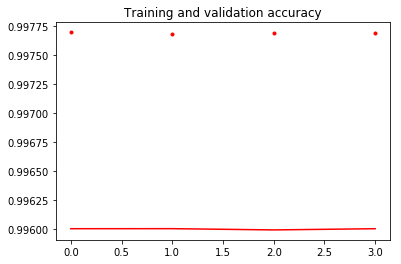

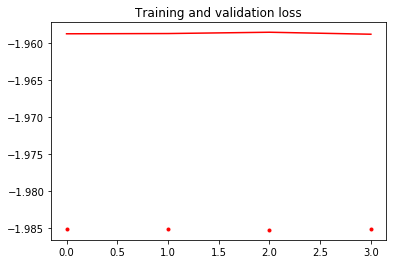

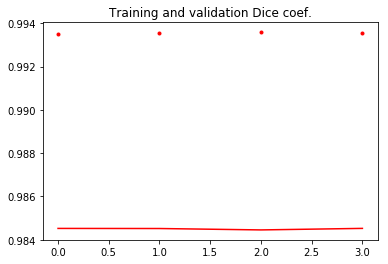

In [7]:
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping, LearningRateScheduler, TensorBoard

weight_file_name = 'unet_no_mask_1024_optimizer-SGD_no_Nesterov'

batch_size = 2
epochs = 100

print(orig_train_tensors.shape)
print(seg_train_tensors.shape)
print(orig_valid_tensors.shape)
print(seg_valid_tensors.shape)
             
callbacks = [EarlyStopping(monitor='val_loss', patience=3, verbose=2, min_delta=1e-4),
             LearningRateScheduler(plateau_then_decl_triangular_lr),
             ModelCheckpoint(monitor='val_loss', filepath='./weights/' + str(weight_file_name) + '.hdf5', 
                             save_best_only=True, save_weights_only=True),
            TensorBoard(log_dir='./logs')]


history = model.fit(orig_train_tensors, seg_train_tensors, batch_size=batch_size, epochs=epochs, verbose=1, 
          validation_data=(orig_valid_tensors, seg_valid_tensors), callbacks=callbacks)

plot_training(history)
